In [2]:
import os
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

homedir = os.getenv("HOME")
path_to_im = homedir+'/Desktop/im.png'

In [3]:
img_only = Image.open(path_to_im)
img = np.asarray(img_only)

height = np.shape(img)[0]
width = np.shape(img)[1]

In [4]:
def get_scaling_fraction(height,width):

    if height>width:
        fraction = width/height
        return 1, fraction
    elif width>height:
        fraction = height/width
        return fraction, 1
    elif width==height:
        return  1, 1
    else:
        print("I don't know what to tell ye. Your width and height are not numbers.")
        return None

In [5]:
#a hearty DANKE to stackexchange

#this function is mine; it helps ensure that pixel cells are square- and not rectangular-shaped
frac_h, frac_w = get_scaling_fraction(height,width)

#resize smoothly down to desired number of pixels for x (70*frac_w) and y (70*frac_h)
imgSmall = img_only.resize((int(70*frac_w),int(70*frac_h)), resample=Image.Resampling.BILINEAR)

#scale back up to original size, if desired...
#result = imgSmall.resize(img_only.size, resample=Image.Resampling.NEAREST)

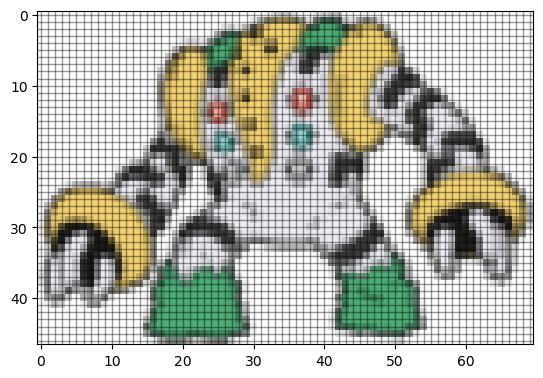

In [6]:
plt.imshow(imgSmall)
for i in range(np.shape(imgSmall)[0]):
    plt.axhline(i,lw=1,color='black',alpha=0.4)
for i in range(np.shape(imgSmall)[1]):
    plt.axvline(i,lw=1,color='black',alpha=0.4)

I clearly need to add a grid offset in order for it to align properly with the pixel cells. After a bit of testing, it appears that 0.35 is sufficient here...

In [7]:
def add_grid(image_array,spacing=0.35):
     
    for n in range(np.shape(image_array)[0]):
        plt.axhline(n+spacing,lw=1,color='black',alpha=0.4)
    for n in range(np.shape(image_array)[1]):
        plt.axvline(n+spacing,lw=1,color='black',alpha=0.4)    

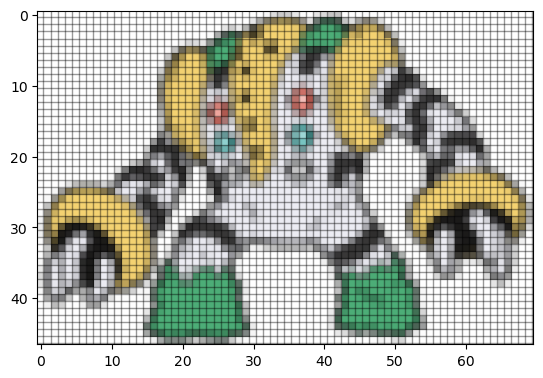

In [8]:
plt.imshow(imgSmall)
add_grid(imgSmall)

let's try one more image -- just for testing.

In [9]:
img_only = Image.open(homedir+'/Desktop/im2.png')
img = np.asarray(img_only)

height = np.shape(img)[0]
width = np.shape(img)[1]

In [10]:
frac_h, frac_w = get_scaling_fraction(height,width)

imgSmall = img_only.resize((int(74*frac_w),int(74*frac_h)), resample=Image.Resampling.BILINEAR)

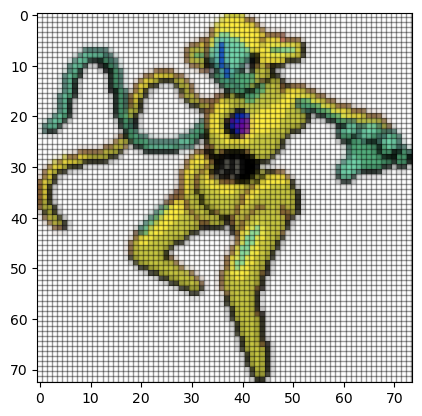

In [11]:
plt.imshow(imgSmall)
add_grid(imgSmall,spacing=0.35)

Okay. 0.35 it is. I'll go ahead and streamline this bugger.
HOWEVER --> when saving the images, it appears that a 0.5 offset is more effective at aligning the grid with the pixels. I do not make the rules.

In [11]:
!python ~/github/pixelate_png/pixelate.py -im_path ~/Desktop/im.png -nx 100 -grid_offset 0.5 - background gray

Image saved to Desktop.

    
    DISCLAIMER NOTES:
        
        --- Be sure to use the original image or even the leftmost panel as a color 
            reference. Indeed, the sharpening (right image panel) might produce 
            some discoloration.
        
        --- The author does not recommend feeding in an already "pixelated" image
            into the program, as the pixel colors will not be as well-defined as 
            the original image. Rather, use the pixelated image AS the pixelated
            image and draw like the wind (but better and more controlled).

        --- Is the quality too...pixelated? Tweak the -nx parameter!
        
        --- Does the grid appear to be offset? Tweak the -offset parameter! 
            Try small floats first, such as 0.35 or 0.50 (the latter is the default).
        
          


# yay.

Let's next try to sharpen some of the images such that the borders and pixel transitions are better resolved (e.g., rather than black to gray to slightly less gray to white for the "edges" of an image, the transition is black to white).

In [12]:
#now we use the package opencv-python...
import cv2

#img = cv2.imread(path_to_im)
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#let's take our new small image
imgt = np.asarray(imgSmall)

try:
    Z = imgt.reshape((-1, 4))
except:
    Z = imgt.reshape((-1,3))
Z = np.float32(Z)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 2   #change this value to dictate the number of represented colors in the image.
ret, label, center = cv2.kmeans(Z, K, None, criteria, 20, cv2.KMEANS_RANDOM_CENTERS)

center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((imgt.shape))

#cv2.imwrite("./output.png", res2)

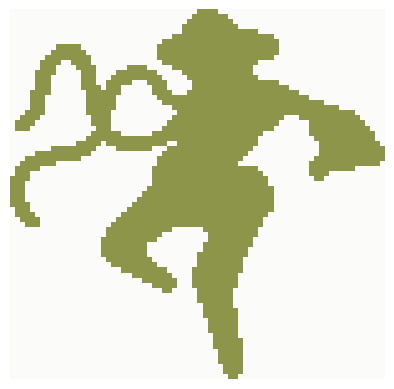

In [13]:
plt.imshow(res2)
plt.axis("off")
plt.show()

In [14]:
#Quite a binary result, yes (I did select K=2, after all). What if I converted this output into
#a boolean?!

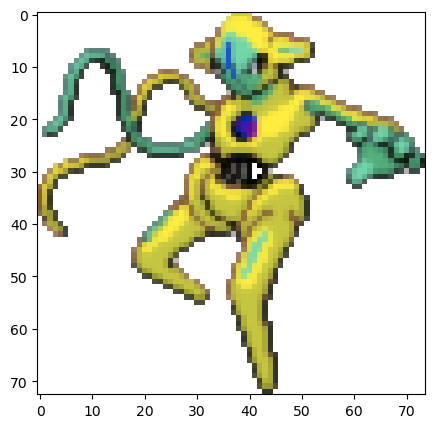

In [15]:
plt.rcParams['axes.facecolor'] = 'gray'

plt.figure(figsize=(5,5))
r = imgt[:,:,0]*(res2[:,:,0] < 250)
g = imgt[:,:,1]*(res2[:,:,1] < 250)
b = imgt[:,:,2]*(res2[:,:,2] < 250)
rgb = np.dstack((r,g,b))
rgb[rgb==0] = 255

plt.imshow(rgb)
#add_grid(rgb)
plt.show()

Not so terrible, I suppose (aside from ANY fully black pixel being converted to white). However, it only adjusts the edges! How about the innards? <br>

In [93]:
#create the sharpening kernel. change 7 to some desired integer (preferably 5<=int<=8)
#to observe how it affects the color palatte and sharpness!
matrix = np.array([[0, -1, 0], [-1, 7, -1], [0, -1, 0]])
kernel = matrix/np.sum(matrix)


#kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]]) 

#sharpen the image 
image2 = cv2.filter2D(imgt, -1, kernel) 

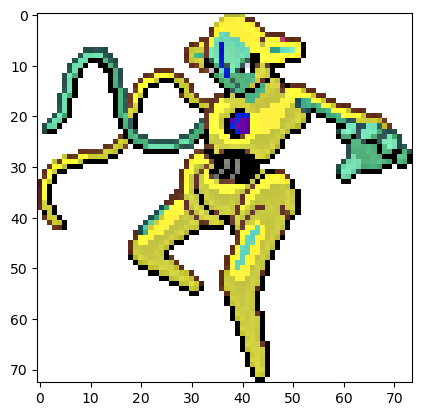

In [94]:
plt.imshow(image2)

### This result would be fabulous is it retained the original color scheme. I am not proficient enough in python to know how to retain this with .png images, so broken it shall remain. Editing the matrix in accordance with the commented instructions can balance sharpness and color preservation, though it is not the most ideal solution. In the meantime...
# Please do use the unpixelated image as a color reference.

In [41]:
#quick approach to printing version of a python package
#!pip show opencv-python | grep Version